<a href="https://colab.research.google.com/github/AmnaNazir20/spam-email-classifier/blob/main/Spam_Email_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Load Dataset**

In [ ]:
from google.colab import files
uploaded=files.upload()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df=pd.read_csv("/content/email.csv")
df.head()

Saving email.csv to email.csv


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# **2. Exploratory Data Analysis (EDA)**

In [ ]:
df.shape
df.info()
encoder=LabelEncoder()
df['Category']=encoder.fit_transform(df['Category'])
df.head()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,0
Category,0
Message,0


In [ ]:
df.duplicated().sum()

np.int64(415)

In [ ]:
df=df.drop_duplicates(keep='first')  # Remove duplicates
df.shape


(5157, 6)

In [ ]:
df['Category'].value_counts()

,count
Category,
0,4516
1,641


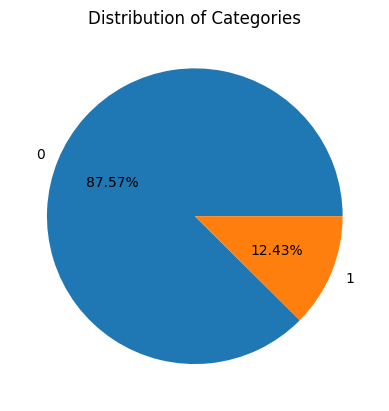

In [34]:
df['Category'].value_counts()
df=df[df['Category'].isin([0,1])]# Keep only 'ham' and 'spam' categories
# Plot distribution
plt.pie(df["Category"].value_counts(),
        labels=df["Category"].value_counts().index,
        autopct='%.2f%%')
plt.title("Distribution of Categories")
plt.show()

# **3. Feature Engineering**

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


<Axes: xlabel='Number_of_characters', ylabel='Count'>

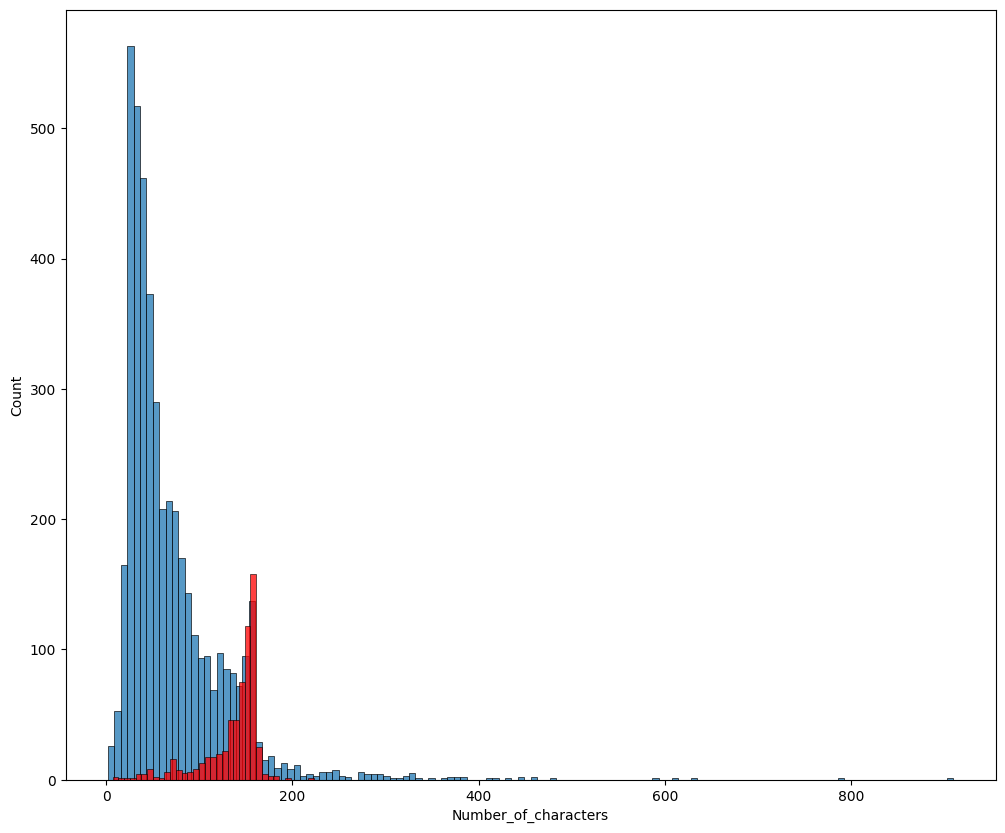

In [ ]:
import nltk
nltk.download('punkt')
df["Number_of_characters"]=df['Message'].apply(len)
df.head()
nltk.download('punkt_tab')
df["numb_of_words"]=df['Message'].apply(lambda x: len(nltk.word_tokenize(x)))
df.head()
df["numb_of_sent"]=df['Message'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()
df[['Number_of_characters',"numb_of_words","numb_of_sent"]].describe()
df[df['Category']==0][['Number_of_characters',"numb_of_words",'numb_of_sent']].describe()
df[df['Category']==1][['Number_of_characters',"numb_of_words",'numb_of_sent']].describe()
plt.figure(figsize=(12,10))
sns.histplot(df[df['Category']==0]['Number_of_characters'])#ham
sns.histplot(df[df['Category']==1]['Number_of_characters'],color='red')#spam

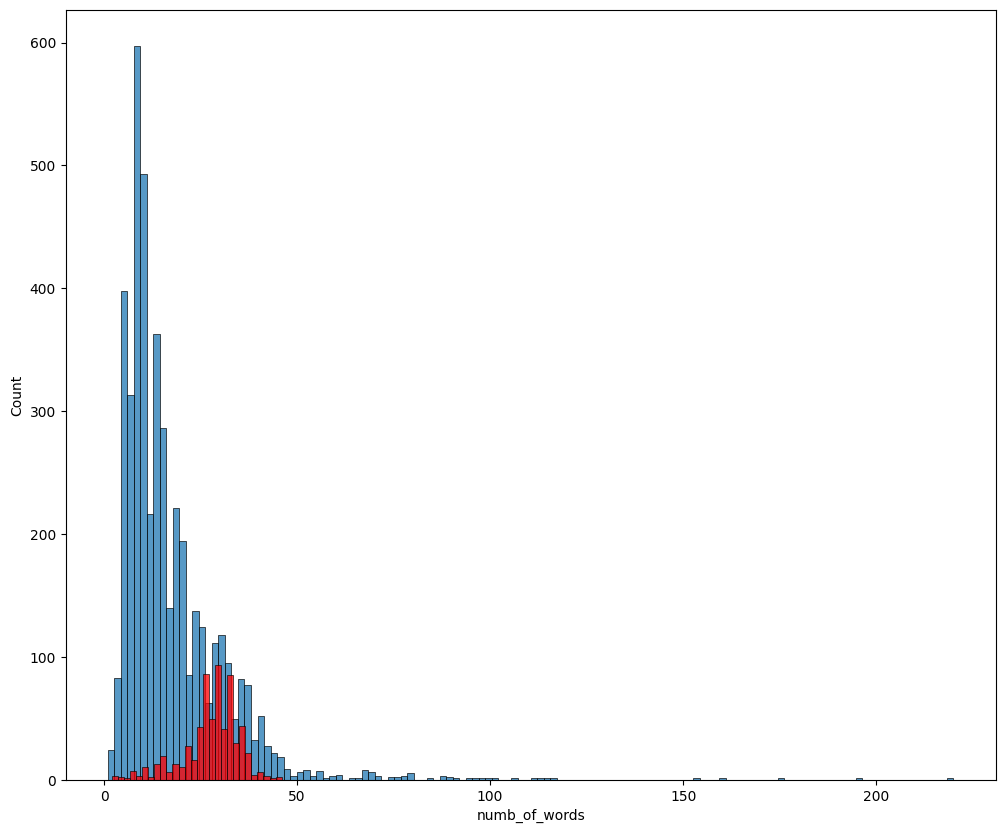

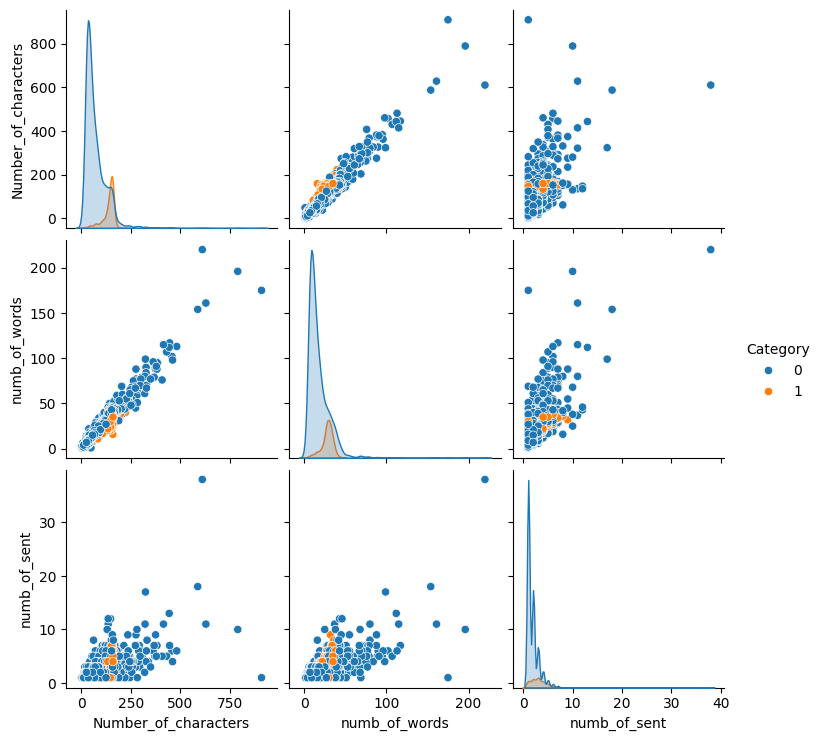

In [ ]:
plt.figure(figsize=(12,10))
sns.histplot(df[df['Category']==0]['numb_of_words'])
sns.histplot(df[df['Category']==1]['numb_of_words'],color='red')
sns.pairplot(df,hue='Category')



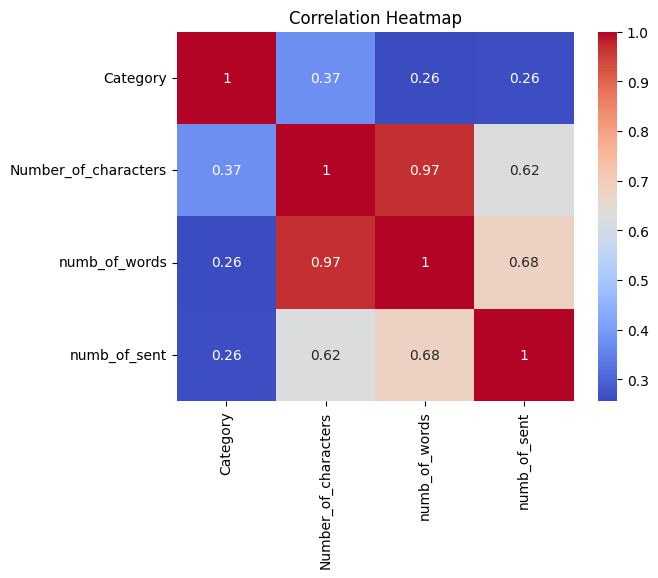

In [ ]:
df_numeric=df.drop(columns=['Message'])
# Draw heatmap
sns.heatmap(df_numeric.corr(),annot=True,cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# **4.Text Preprocessing**

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from string import punctuation
nltk.download('stopwords')
ps=PorterStemmer()
def transform_text(text):
   text=text.lower()
   text=word_tokenize(text)
   y=[]
   for i in text:
    if i.isalnum():
      y.append(i)
   temp=[]
   for i in y:
    if i not in stopwords.words('english') and i not in punctuation:
      temp.append(i)
   final=[]
   for i in temp:
    final.append(ps.stem(i))
   return " ".join(final)
df["transform_text"]=df["Message"].apply(transform_text)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Category,Message,Number_of_characters,numb_of_words,numb_of_sent,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


# **5. Feature Extraction using TF-IDF**

In [ ]:
vectorizer = TfidfVectorizer()
X=vectorizer.fit_transform(df['transform_text'])
y=df['Category']
sm=SMOTE(random_state=42)
X_resampled,y_resampled=sm.fit_resample(X,y)

# **6. Model Training: Naive Bayes**

In [ ]:
import time
# Split resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
start = time.time()
# Train
model = MultinomialNB()
model.fit(X_train, y_train)
end = time.time()


# ***Evalution And confusion Matrix & ROC Curve:**

Training Time: 0.0090 seconds
Accuracy: 0.981737686773658
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       895
           1       0.98      0.99      0.98       912

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807



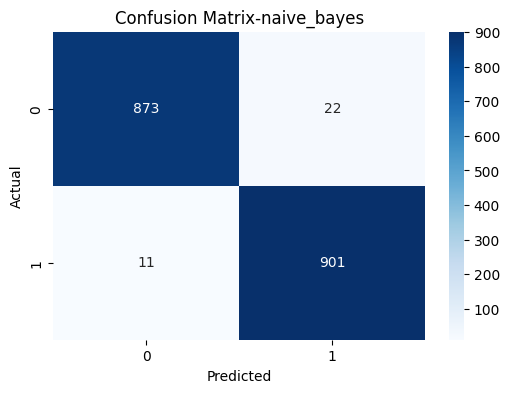

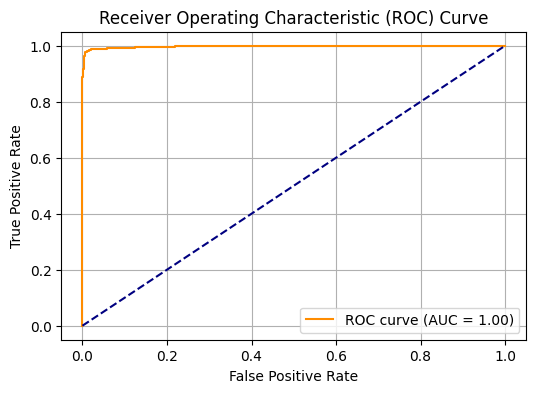

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Predict
y_pred = model.predict(X_test)
print(f"Training Time: {end - start:.4f} seconds")
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm_df = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix-naive_bayes")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Predict probabilities for the positive class (Spam = 1)
y_proba = model.predict_proba(X_test)[:, 1]  # Only take probability for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **7. Model Training: Logistic Regression (Default)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
start_time = time.time()

# Train default logistic regression
default_lr = LogisticRegression(max_iter=1000)
default_lr.fit(X_train, y_train)
end_time = time.time()
# Predict
y_pred_default = default_lr.predict(X_test)

# ***Evalution And confusion Matrix & ROC Curve(Default):**

 Default Logistic Regression
Training Time: 0.0090 seconds
Accuracy: 0.9789706696181516
Confusion Matrix:
 [[881  14]
 [ 24 888]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       895
           1       0.98      0.97      0.98       912

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807



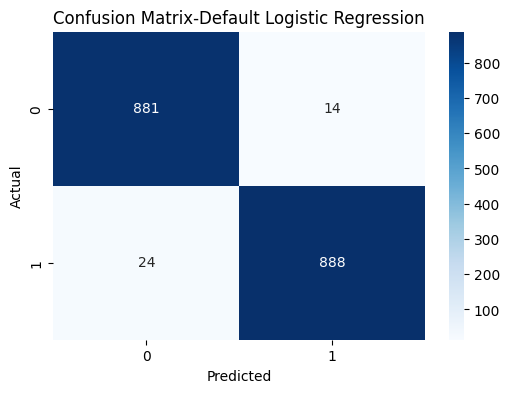

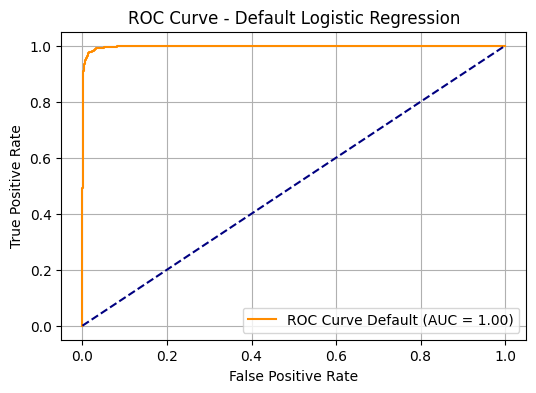

In [32]:
# Evaluate
print(" Default Logistic Regression")
print(f"Training Time: {end - start:.4f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_default))
print("Classification Report:\n", classification_report(y_test, y_pred_default))
cm_df = confusion_matrix(y_test, y_pred_default)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix-Default Logistic Regression")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
# Predict probabilities for class 1 (Spam)
y_proba = default_lr.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve Default (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Default Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **8. Model Training: Logistic Regression (Tuned)**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}

# Start timer
start_time = time.time()

# Train using GridSearchCV
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

# End timer
end_time = time.time()

# Training time in seconds
training_time = end_time - start_time

# Best model
tuned_lr = grid.best_estimator_



# ***Evalution And confusion Matrix & ROC Curve(Tuned):**

📌 Tuned Logistic Regression
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.993912562257886
Training Time: 5.60 seconds
Confusion Matrix:
 [[887   8]
 [  3 909]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       895
           1       0.99      1.00      0.99       912

    accuracy                           0.99      1807
   macro avg       0.99      0.99      0.99      1807
weighted avg       0.99      0.99      0.99      1807



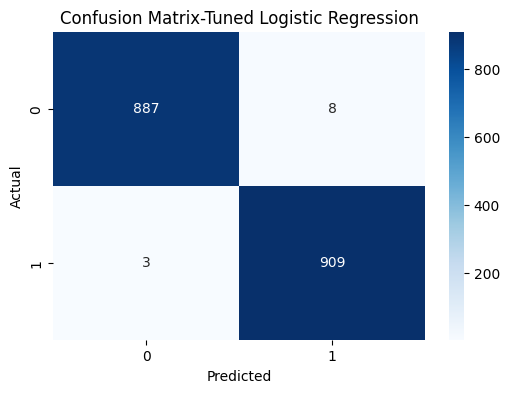

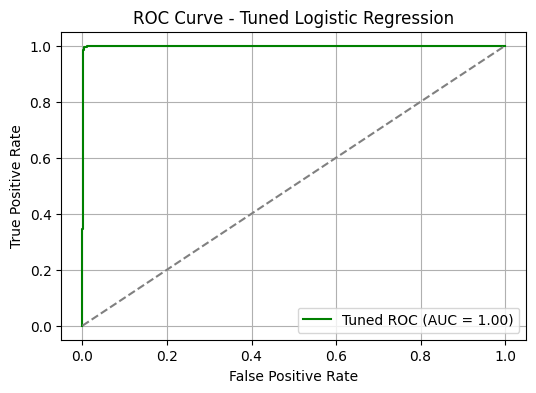

In [33]:
# Predict
y_pred_tuned = tuned_lr.predict(X_test)

# Evaluation
print("📌 Tuned Logistic Regression")
print("Best Parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Training Time: {:.2f} seconds".format(training_time))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))
cm_df = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix-Tuned Logistic Regression")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
# Predict probabilities for class 1
y_proba_tuned = tuned_lr.predict_proba(X_test)[:, 1]

# ROC curve calculation
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plot ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_tuned, tpr_tuned, color='green', label=f'Tuned ROC (AUC = {roc_auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **9. Predict Function**

In [ ]:
def predict_message(msg):
    cleaned = transform_text(msg)                       # Clean and transform the text
    vec = vectorizer.transform([cleaned]).toarray()    # Convert to vector using the same vectorizer
    pred = model.predict(vec)[0]                    # Predict using Naive
    return "Spam" if pred == 1 else "Ham"
msg1 = "Congratulations! You have won a $1000 Walmart gift card. Click to claim now."
msg2 = "Hey, are we still meeting at 6 PM today?"

print("Prediction 1:", predict_message(msg1))  # Likely "Spam"
print("Prediction 2:", predict_message(msg2))  # Likely "Ham"

Prediction 1: Spam
Prediction 2: Ham
